In [26]:
from pathlib import Path

import uproot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from gsfanalysis.pandas_import import *
from gsfanalysis.trackstates_plots import *
from gsfanalysis.tracksummary_plots import *
from gsfanalysis.core_tail_utils import rms

In [171]:
def mode(data, tol=0.0001, max_iter=10):
    mask = np.ones(len(data))
    
    for _ in range(max_iter):
        hist, bins = np.histogram(data[mask])
        i = np.argmax(hist)
        mode = 0.5 * (bins[i] + bins[i+1])
        
        if bins[i+1] - bins[i] <= tol or len(bins) == 2:
            return mode
        
        mask = (data > bins[max(0,i-1)]) & (data < bins[min(i+2, len(bins)-1)])
        
    print("Warning: mode accuracy is only: ", bins[i+1] - bins[i])
    return mode

In [172]:
def quantile_interval(data, q, midpoint=0):
    sorted_data = np.sort(data - midpoint)
    q = np.quantile(abs(sorted_data), q)
    interval = (
        midpoint + sorted_data[ sorted_data > -q ][0],
        midpoint + sorted_data[ sorted_data < q ][-1]
    )
    
    return 0.5*(interval[1]-interval[0]), interval

In [213]:
def plot_sets(sets, ylog=False, mean_height=50):
    fig, axes = plt.subplots(1, 3, figsize=(16,5))
    
    keys = ["res_eQOP_fit", "res_ePNORM_fit", "pull_eQOP_fit"]
    base_ranges = [(-0.05,0.05), (-0.3,0.3), (-2,2)]
    
    # First evaluate ranges, so that we have sane binning afterwards for the hist
    for i, key  in enumerate(keys):
        for df, _, _ in sets:
            m = mode(df[key])
            q = np.quantile(abs(df[key] - m), 0.95)
            
            base_ranges[i] = (
                min([base_ranges[i][0], m-q, np.mean(df[key])]),
                max([base_ranges[i][1], m+q, np.mean(df[key])]),
            )

    for ax, key, clip_range in zip(axes, keys, base_ranges):        
        for df, label, color in sets:
            histopts = dict(bins=100, alpha=0.3, color=color, zorder=-10)

            sample_mode = mode(df[key])

            q95 = np.quantile(abs(df[key] - sample_mode), 0.95)
            q95_interval = (sample_mode - q95, sample_mode + q95)
            #q95, q95_interval = quantile_interval(df[key], 0.95, sample_mode)
            
            q68 = np.quantile(abs(df[key] - sample_mode), 0.68)
            q68_interval = (sample_mode - q68, sample_mode + q68)
            #q68, q68_interval = quantile_interval(df[key], 0.68, sample_mode)

            hist, _, _ = ax.hist(np.clip(df[key], *clip_range),
                                 #label="{} - rms: {:.3f}".format(label, rms(df[key])),
                                 label=label,
                                 range=clip_range,
                                 **histopts)

            ax.vlines([sample_mode], ymin=0, ymax=0.66*max(hist), color=color, label="mode: {:.3f}".format(sample_mode), ls="--", zorder=-3, lw=1)

            ax.plot(q95_interval, 2*[0.33*max(hist)], "-o", color=color, 
                    #label="Q95: {:.3f}\n   rms: {:.3f}".format(q95, rms(df[key].between(*q95_interval))))
                    label="Q95: {:.3f}".format(q95))
            ax.plot(q68_interval, 2*[0.66*max(hist)], "-s", color=color,
                    #label="Q68: {:.3f}\n   rms: {:.3f}".format(q68, rms(df[key].between(*q68_interval))))
                    label="Q68: {:.3f}".format(q68))

            sample_mean = np.mean(df[key])
            ax.vlines([sample_mean], ymin=0, ymax=mean_height, color=color, label="mean: {:.3f}".format(sample_mean), zorder=-3, lw=3)

    legend_opts = dict(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

    if ylog:
        for ax in axes:
            ax.set_yscale('log')
            
    axes[0].set_title("res QOP")
    axes[0].legend(**legend_opts)
    axes[0].set_xlabel("${qop}_{true} - {qop}_{fit} \quad [GeV^{-1}]$")

    axes[1].set_title("res PNORM")
    axes[1].legend(**legend_opts)
    axes[1].set_xlabel("$({p}_{true} - {p}_{fit}) \;/\; p_{true}$")

    axes[2].set_title("pull QOP")
    axes[2].legend(**legend_opts)
    axes[2].set_xlabel("$({qop}_{true} - {qop}_{fit}) \;/\; \sigma_{qop,fit}$")
    
    fig.suptitle("Without outliers ({} samples)".format(len(sets[0][0])))
    fig.tight_layout
    return fig, axes

In [214]:
summary_gsf_1cmp = uproot_to_pandas(
    uproot.open("../output/c1_n20/root/tracksummary_gsf.root:tracksummary"),
)

summary_gsf_20cmp = uproot_to_pandas(
    uproot.open("../output/c20_n20/root/tracksummary_gsf.root:tracksummary"),
)

summary_kf = uproot_to_pandas(
    uproot.open("../output/c20_n20/root/tracksummary_kf.root:tracksummary"),
)

len(summary_gsf_1cmp), len(summary_gsf_20cmp), len(summary_kf)

(8784, 8762, 8863)

In [215]:
mode(summary_gsf_20cmp["res_ePNORM_fit"], tol=0.0001)

-0.006288704928010702

In [216]:
summary_gsf_20cmp_no, summary_kf_no = remove_outliers_and_unify_index(
    summary_gsf_20cmp.copy(), summary_kf.copy()
)

len(summary_gsf_20cmp_no), len(summary_kf_no)

(7704, 7704)

(<Figure size 1600x500 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'res QOP'}, xlabel='${qop}_{true} - {qop}_{fit} \\quad [GeV^{-1}]$'>,
        <AxesSubplot: title={'center': 'res PNORM'}, xlabel='$({p}_{true} - {p}_{fit}) \\;/\\; p_{true}$'>,
        <AxesSubplot: title={'center': 'pull QOP'}, xlabel='$({qop}_{true} - {qop}_{fit}) \\;/\\; \\sigma_{qop,fit}$'>],
       dtype=object))

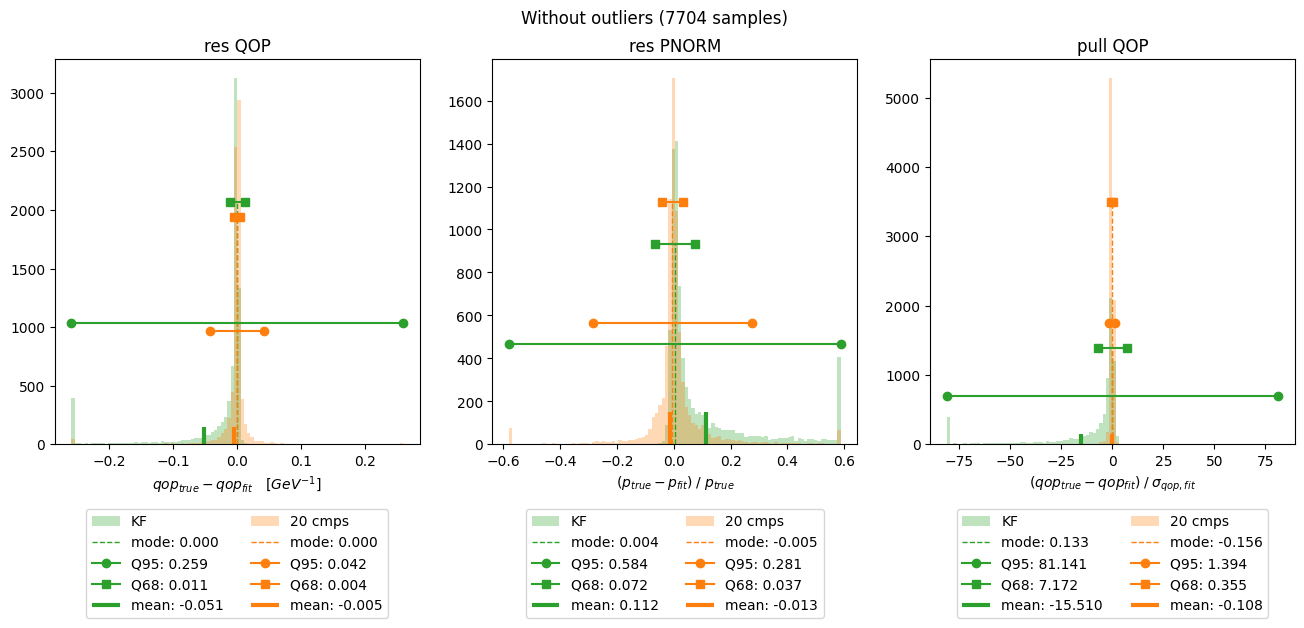

In [217]:
sets = [
    (summary_kf_no, "KF", "tab:green"),
#    (summary_gsf_1cmp, "1 cmp", "tab:blue"),
    (summary_gsf_20cmp_no, "20 cmps", "tab:orange"),
]

plot_sets(sets, mean_height=150)

In [218]:
summary_gsf_20cmp_no, summary_gsf_1cmp_no = remove_outliers_and_unify_index(
    summary_gsf_20cmp_no.copy(), summary_gsf_1cmp.copy()
)

len(summary_gsf_20cmp_no), len(summary_gsf_1cmp_no)

(6610, 6610)

(<Figure size 1600x500 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'res QOP'}, xlabel='${qop}_{true} - {qop}_{fit} \\quad [GeV^{-1}]$'>,
        <AxesSubplot: title={'center': 'res PNORM'}, xlabel='$({p}_{true} - {p}_{fit}) \\;/\\; p_{true}$'>,
        <AxesSubplot: title={'center': 'pull QOP'}, xlabel='$({qop}_{true} - {qop}_{fit}) \\;/\\; \\sigma_{qop,fit}$'>],
       dtype=object))

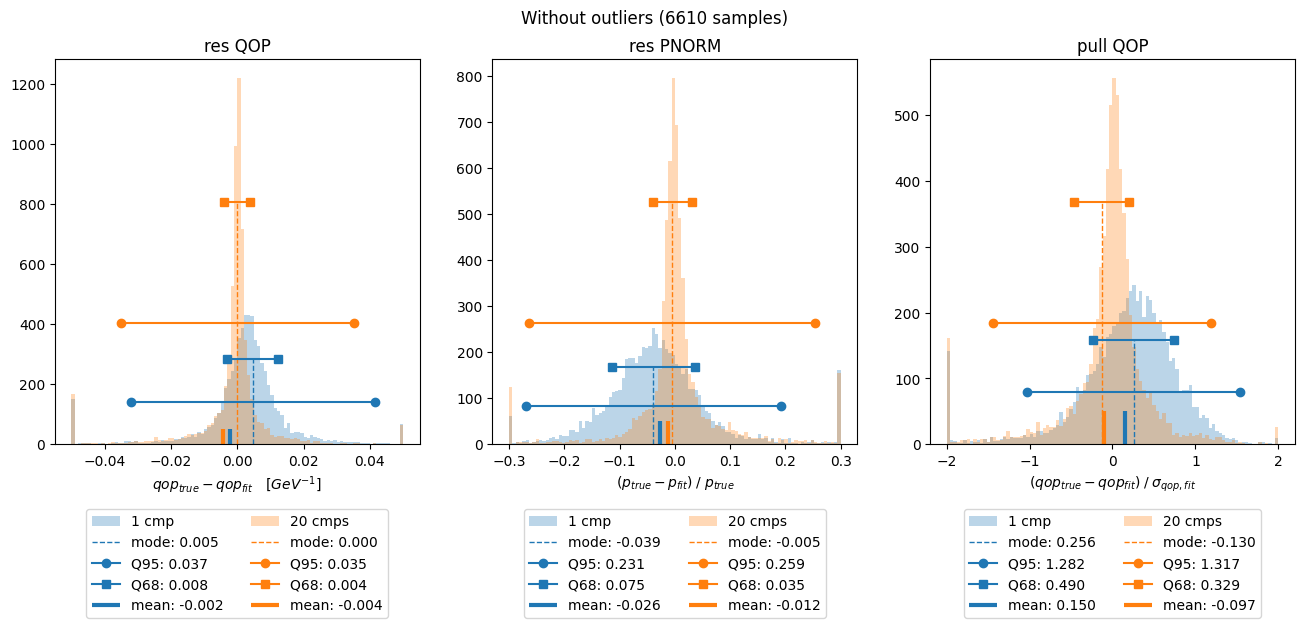

In [219]:
sets = [
    (summary_gsf_1cmp_no, "1 cmp", "tab:blue"),
    (summary_gsf_20cmp_no, "20 cmps", "tab:orange"),
]

plot_sets(sets)

Text(0.5, 1.0, 'Quantile sweep MEAN - res_eQOP_fit')

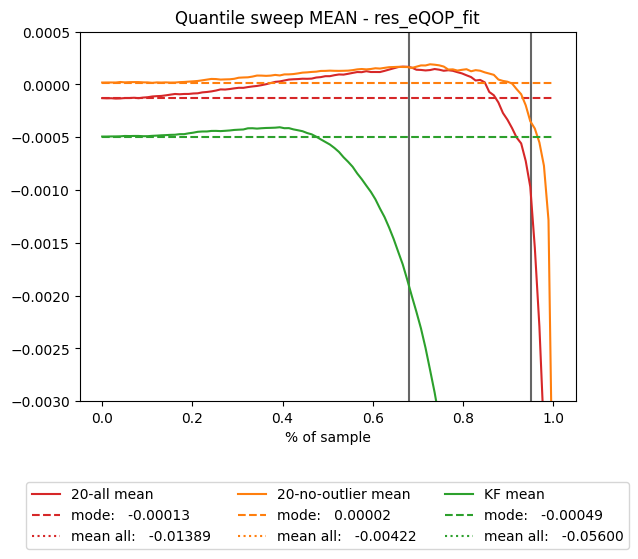

In [238]:
fig, ax = plt.subplots()

for df, label, color in zip([summary_gsf_20cmp, summary_gsf_20cmp_no, summary_kf],
                            ["20-all", "20-no-outlier", "KF"],
                            ["tab:red", "tab:orange", "tab:green"]):
    means = []
    sample_mode = mode(df["res_eQOP_fit"])

    qs = np.linspace(0,1,100)
    for q in qs:
        q_width = np.quantile(abs(df["res_eQOP_fit"] - sample_mode), q)
        q_mask = df["res_eQOP_fit"].between(sample_mode-q_width, sample_mode+q_width)
        means.append(np.mean(df["res_eQOP_fit"][q_mask]))

    line = ax.plot(qs, means, label=label+" mean", c=color)[0]
    ax.hlines([sample_mode], xmin=0, xmax=1, label="mode:   {:.5f}".format(sample_mode), linestyles=["dashed"], color=line._color)
    ax.hlines([means[-1]], xmin=0, xmax=1, label="mean all:   {:.5f}".format(means[-1]), linestyles=["dotted"], color=line._color)
    

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncols=3)
ax.set_xlabel("% of sample")
ax.set_ylim(-0.003, 0.0005)

ax.vlines([0.95, 0.68], ax.get_ylim()[0], ax.get_ylim()[1], color="black", zorder=-10, alpha = 0.6)

ax.set_title("Quantile sweep MEAN - res_eQOP_fit")

Text(0.5, 1.0, 'Quantile sweep RMS - res_eQOP_fit')

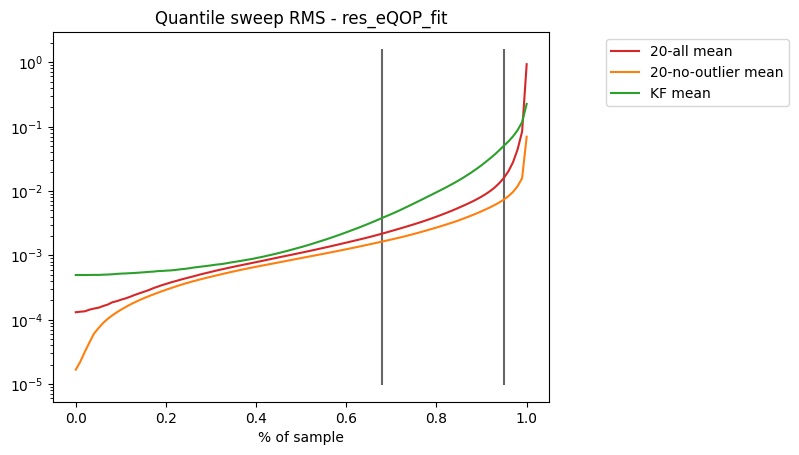

In [239]:
fig, ax = plt.subplots()

for df, label, color in zip([summary_gsf_20cmp, summary_gsf_20cmp_no, summary_kf],
                            ["20-all", "20-no-outlier", "KF"],
                            ["tab:red", "tab:orange", "tab:green"]):
    rmss = []
    sample_mode = mode(df["res_eQOP_fit"])

    qs = np.linspace(0,1,100)
    for q in qs:
        q_width = np.quantile(abs(df["res_eQOP_fit"] - sample_mode), q)
        q_mask = df["res_eQOP_fit"].between(sample_mode-q_width, sample_mode+q_width)
        rmss.append(rms(df["res_eQOP_fit"][q_mask]))

    line = ax.plot(qs, rmss, label=label+" mean", c=color)[0]

ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax.set_xlabel("% of sample")
ax.set_yscale('log')
ax.vlines([0.95, 0.68], ax.get_ylim()[0], ax.get_ylim()[1], color="black", zorder=-10, alpha = 0.6)
ax.set_title("Quantile sweep RMS - res_eQOP_fit")